# SSICOV RSVD Example

Run this notebook from the `examples/` directory so `data/BridgeData.mat` is found.


In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
from scipy.signal import periodogram

from fast_ssi import cluster_data_by_frequency, plotStabDiag
from fast_ssi.SSICOV_RSVD import SSICOV

DATA_DIR = Path("data").resolve()
mat = loadmat(DATA_DIR / "BridgeData.mat")
t, rz, wn = mat["t"], mat["rz"], mat["wn"]

## Load and prepare the dataset

The bridge data contains:
- `t`: time vector
- `rz`: displacement measurements from multiple sensors
- `wn`: natural frequencies (target values for validation)

The data is loaded from a MATLAB file and will be used to identify the modal parameters of the bridge structure.

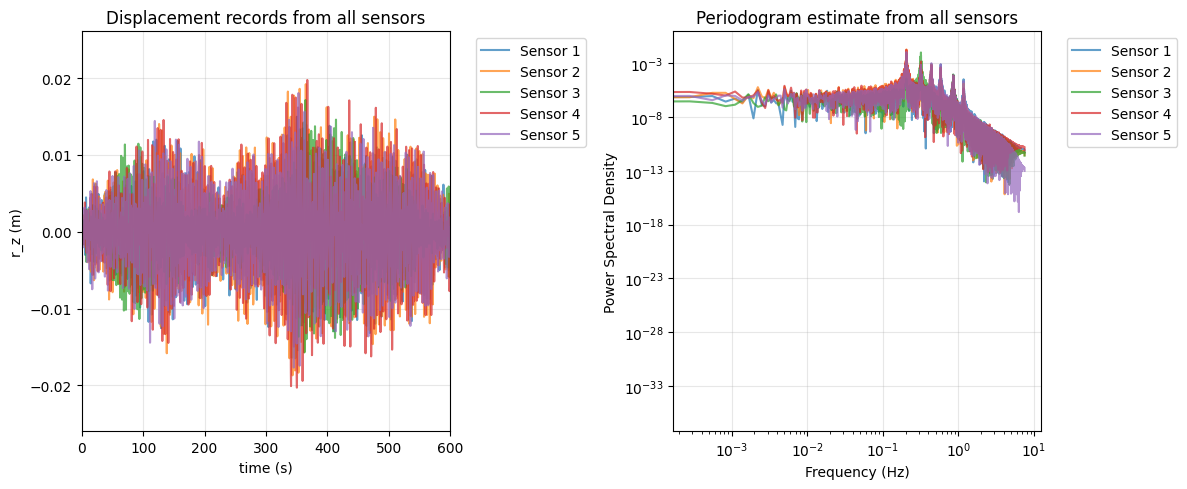

In [3]:
# Quick visualization of the loaded data
dt = np.median(np.diff(t))
fs = 1 / dt

plt.figure(figsize=(12, 5))

# Plot sensor data
plt.subplot(121)
for i in range(rz.shape[0]):
    plt.plot(t[0], rz[i, :], alpha=0.7, label=f"Sensor {i + 1}")
plt.xlim([0, 600])
plt.xlabel("time (s)")
plt.ylabel("r_z (m)")
plt.title("Displacement records from all sensors")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, alpha=0.3)

# Plot periodogram
plt.subplot(122)
for i in range(rz.shape[0]):
    f, Pxx = periodogram(rz[i, :], fs=fs)
    plt.plot(f, Pxx, alpha=0.7, label=f"Sensor {i + 1}")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density")
plt.title("Periodogram estimate from all sensors")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.gcf().set_facecolor("w")
plt.show()

In [4]:
def plot_data(t, rz, wn):
    _fn_target = wn / (2 * np.pi)
    dt = np.median(np.diff(t))
    fs = 1 / dt

    plt.figure(figsize=(12, 5))

    # Subplot 1: Sensor data
    plt.subplot(121)
    for i in range(rz.shape[0]):
        plt.plot(t[0], rz[i, :], alpha=0.7, label=f"Sensor {i + 1}")
    plt.xlim([0, 600])
    plt.xlabel("time (s)")
    plt.ylabel("r_z (m)")
    plt.title("Displacement records from all sensors")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(True, alpha=0.3)

    # Subplot 2: Periodogram
    plt.subplot(122)
    for i in range(rz.shape[0]):
        f, Pxx = periodogram(rz[i, :], fs=fs)
        plt.plot(f, Pxx, alpha=0.7, label=f"Sensor {i + 1}")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power Spectral Density")
    plt.title("Periodogram estimate from all sensors")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.gcf().set_facecolor("w")
    plt.show()

## Visualization function

The `plot_data` function creates a 2x2 subplot showing:
- Time-domain displacement records from sensors 2 and 5
- Power Spectral Density (PSD) estimates to identify dominant frequencies

This helps visualize the input data quality and frequency content before running the SSI algorithm.

## Run SSI-COV with Randomized SVD and visualize results

Here we:
1. Set the SSI parameters:
   - `fs = 15`: Sampling frequency (Hz)
   - `Ts = 10`: Time lag parameter
   - `Nmin = 7, Nmax = 50`: Range of model orders to test
   - `Nc`: Number of channels (sensors)

2. Initialize and run the SSICOV algorithm using randomized SVD (RSVD) for efficiency

3. Cluster the identified poles by frequency to group similar modes

4. Plot the stabilization diagram showing stable poles across model orders
   - **Note**: The `plotStabDiag` function has a `stable_only` parameter (defaults to `False`)
   - Set `stable_only=True` to plot only stable poles and hide "new pole" markers
   - This can help focus on physically meaningful modes by reducing visual clutter

5. Display the input data and PSD estimates for validation

NexT, elapsed time: 0.037344 seconds
Selected Rank:107
 RSVD Elapse time 0.00908207893371582s
blockToeplitz, elapsed time: 0.022240 seconds
modalID, elapsed time: 0.004682 seconds
modalID, elapsed time: 0.003101 seconds
stabilityCheck, elapsed time: 0.002318 seconds
modalID, elapsed time: 0.002868 seconds
stabilityCheck, elapsed time: 0.002316 seconds
modalID, elapsed time: 0.002739 seconds
stabilityCheck, elapsed time: 0.002024 seconds
modalID, elapsed time: 0.002705 seconds
stabilityCheck, elapsed time: 0.001855 seconds
modalID, elapsed time: 0.002649 seconds
stabilityCheck, elapsed time: 0.001815 seconds
modalID, elapsed time: 0.002385 seconds
stabilityCheck, elapsed time: 0.001844 seconds
modalID, elapsed time: 0.002404 seconds
stabilityCheck, elapsed time: 0.001464 seconds
modalID, elapsed time: 0.002144 seconds
stabilityCheck, elapsed time: 0.001497 seconds
modalID, elapsed time: 0.002121 seconds
stabilityCheck, elapsed time: 0.001677 seconds
modalID, elapsed time: 0.002001 secon

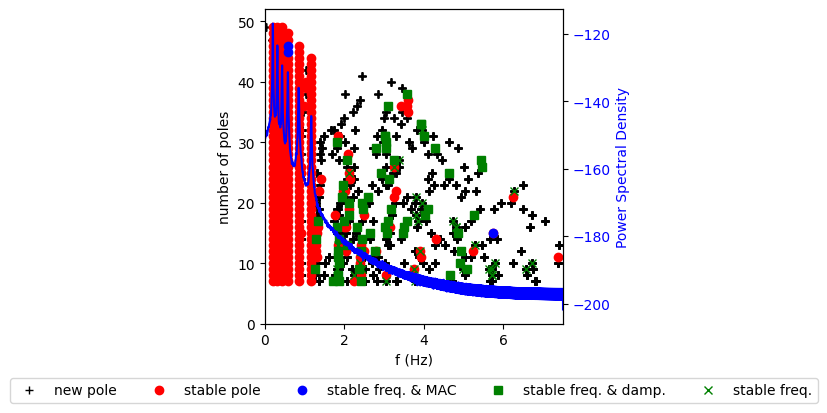

In [5]:
fs = 15
acc = rz.T
Nmin = 7
Nmax = 50
Nc = acc.shape[1]
Ts = 10

ssi = SSICOV(acc, fs, Ts, Nc, Nmax, Nmin)
fnS, zetaS, phiS, MACS, stability_status, fn2 = ssi.run()

num_clusters = 6
cluster_data_by_frequency(fnS, zetaS, phiS, num_clusters)
plotStabDiag(fn2, acc, fs, stability_status, Nmin, Nmax, acc.shape[1], 0, 7.5)

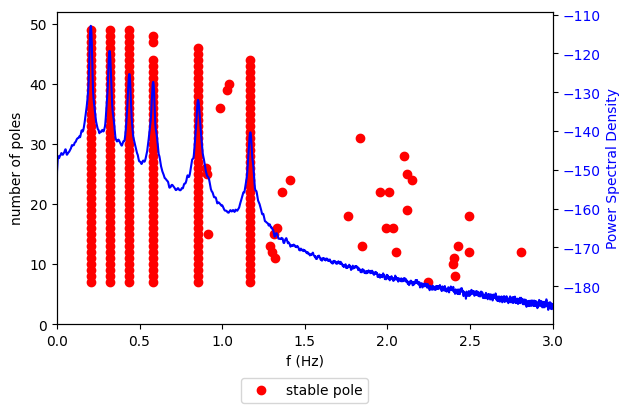

In [6]:
plotStabDiag(
    fn2, acc, fs, stability_status, Nmin, Nmax, acc.shape[1], 0, 3, stable_only=True
)

## Stabilization diagram with only stable poles

For a cleaner view focused on physically meaningful modes, we can plot the stabilization diagram with only stable poles by setting `stable_only=True`. This removes the "new pole" markers (black +) and shows only the poles that meet stability criteria.